In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a simple CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.dropout1(x)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = nn.functional.log_softmax(x, dim=1)
        return output

# Initialize the model and send it to the device (GPU or CPU)
model = CNN().to(device)

# Define the loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Dataset transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

# Data loader
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Function to train the model
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

# Function to test the model
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_function(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n')

# Training loop
epochs = 3  # For demo purposes, we'll just run one epoch
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

# Save the trained model
torch.save(model.state_dict(), "./mnist_cnn.pt")

print("Training complete and model saved.")


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303530
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.255237
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.596011
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.505686
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.386947
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.324183
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.238933
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.183291
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.250939
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.316192
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.236451
Train Epoch: 1 [28160/60000 (47%)]	Loss: 0.260667
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.238223
Train Epoch: 1 [33280/60000 (55%)]	Loss: 0.191984
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.199362
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.142176
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.207500
Train Epoch: 1 [43520/60000 (72%)]	Loss: 0.146832
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.178068
Train Epoch: 1 [48640/60000 (81%)]	Loss: 0.190090
Train Epoc

In [6]:
transformed_images = torch.load(f"transformed_dataset_1.pth")

In [18]:
for i in range(1,5):
    data = torch.load(f"transformed_dataset_{i}.pth")
    transformed_images = data["images"]
    labels = data['labels']

torch.Size([60000, 28, 28]) torch.Size([60000])
torch.Size([60000, 28, 28]) torch.Size([60000])
torch.Size([60000, 28, 28]) torch.Size([60000])
torch.Size([60000, 28, 28]) torch.Size([60000])


In [26]:
import torch
from torch.utils.data import DataLoader, TensorDataset

batch_size = 256
# 정확도를 계산하는 함수
def calculate_accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# 변형된 데이터셋에 대한 정확도를 평가하는 함수
def evaluate_transformed_datasets(model, num_datasets):
    accuracies = []
    for i in range(1, num_datasets + 1):
        # 변형된 데이터셋 로드
        data = torch.load(f"transformed_dataset_{i}.pth")
        transformed_images = data["images"]
        labels = data['labels']

        # Ensure the images have the correct shape
        transformed_images = transformed_images.unsqueeze(1)  # Add channel dimension

        # DataLoader 생성
        transformed_dataset = TensorDataset(transformed_images, labels)
        transformed_loader = DataLoader(transformed_dataset, batch_size=batch_size, shuffle=False)

        # 정확도 계산
        accuracy = calculate_accuracy(model, transformed_loader)
        accuracies.append(accuracy)
        print(f"Accuracy on transformed dataset {i}: {accuracy*100:.2f}%")
    
    return accuracies


# 4개의 변형된 데이터셋에 대해 모델의 정확도 평가
evaluate_transformed_datasets(model, 8)

Accuracy on transformed dataset 1: 98.04%
Accuracy on transformed dataset 2: 95.62%
Accuracy on transformed dataset 3: 92.66%
Accuracy on transformed dataset 4: 85.71%
Accuracy on transformed dataset 5: 73.46%
Accuracy on transformed dataset 6: 55.98%
Accuracy on transformed dataset 7: 42.12%
Accuracy on transformed dataset 8: 29.48%


[0.9803833333333334,
 0.9562166666666667,
 0.9266333333333333,
 0.8570833333333333,
 0.7345666666666667,
 0.5597833333333333,
 0.4212,
 0.29483333333333334]

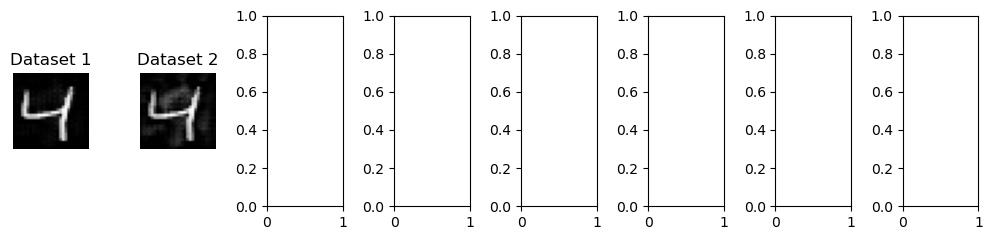

In [3]:
import matplotlib.pyplot as plt
import torch
# Set up the plot
fig, axes = plt.subplots(1, 8, figsize=(10, 2.5))  # 1 row, 4 columns for the 4 datasets
axes = axes.ravel()  # Flatten the array of axes

# Load the first image from each dataset and plot it
for i in range(2):
    # Load the dataset
    data = torch.load(f"transformed_dataset_{i+1}.pth")
    transformed_images = data["images"]
    labels = data['labels']
    
    # Select the first image
    image = transformed_images[2]
    
    # Check if the image needs to be reshaped
    if image.ndim > 2:
        image = image.squeeze()  # Remove channel dimension if it's there
    
    # Plot the image
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f'Dataset {i+1}')
    axes[i].axis('off')  # Hide the axes ticks

# Display the plot
plt.tight_layout()
plt.show()
